In [1]:
import yfinance as yf
import datetime
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline
%matplotlib notebook

In [2]:
vrsn = pdr.get_data_yahoo('VRSN', start='2019-09-27')
sp = pdr.get_data_yahoo('^GSPC', start='2019-09-27')
# end='2022-05-10'

In [3]:
vrsn.Close.corr(sp.Close)

0.5078715246383848

<IPython.core.display.Javascript object>


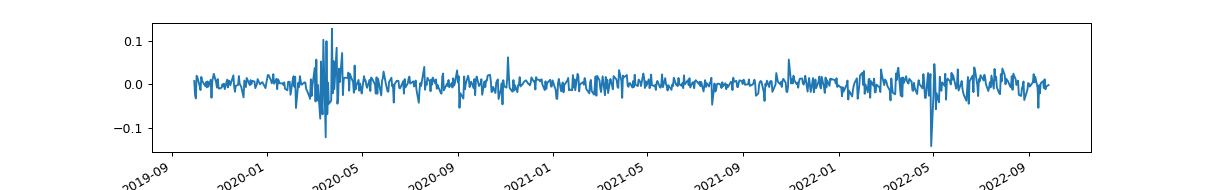

In [10]:
returns = vrsn.Close.pct_change().dropna()
returns.plot(label = "returns")
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(returns)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.976784
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [12]:
from arch import arch_model
garch_1_1 = arch_model(returns,mean='Constant',vol='GARCH')
result=garch_1_1.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 156097809.00722262
Iteration:      2,   Func. Count:     18,   Neg. LLF: 18997873222422.617
Iteration:      3,   Func. Count:     29,   Neg. LLF: 44731.37657569329
Iteration:      4,   Func. Count:     39,   Neg. LLF: -2017.335876863427
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2017.335877926091
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 4


D:\Anaconda\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003932. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [13]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2017.34
Distribution:                  Normal   AIC:                          -4026.67
Method:            Maximum Likelihood   BIC:                          -4008.17
                                        No. Observations:                  754
Date:                Mon, Sep 26 2022   Df Residuals:                      753
Time:                        23:43:34   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.2996e-04  5.489e-04      0.783      0.433 [-6.459e-04,1.506e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.9323e-05  5.329e-06      7.380  1.588e-13 [2.888e-05,4.977e-05]
alpha[1]       0.2000  6.497e-02      3.079  2.080e-03   [7.267e-02,  0.327]
beta[1]        0.7000  3.133e-02     22.343 1.402e-110     [  0.639,  0.761]
============================================================================

Covariance estimator: robust
"""

<IPython.core.display.Javascript object>


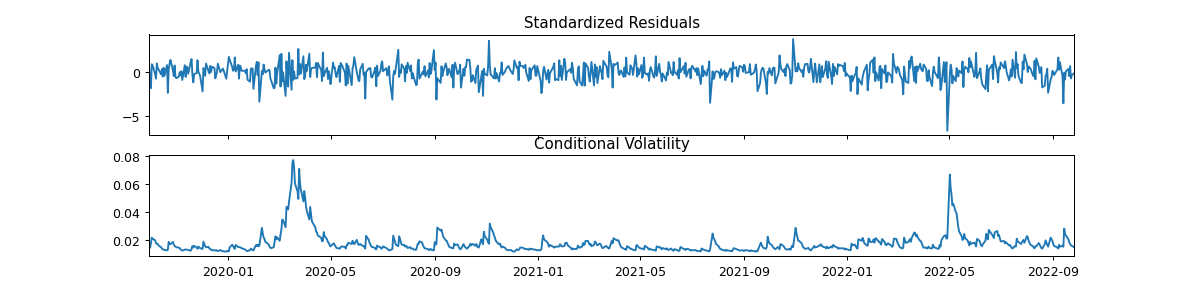

In [16]:
result.plot()
plt.show()

<IPython.core.display.Javascript object>


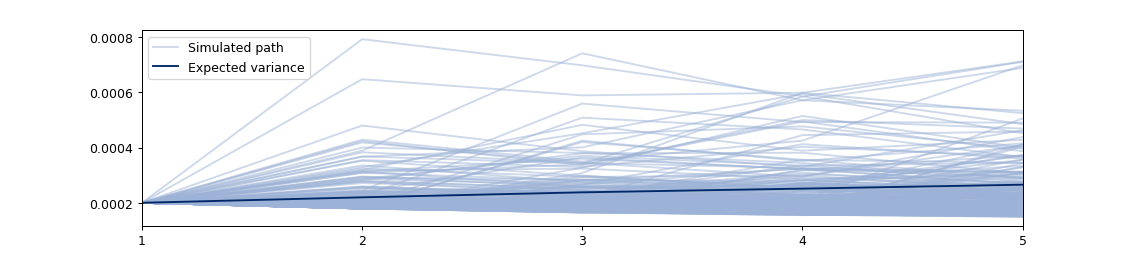

In [17]:
forecasts = result.forecast(horizon=5, method="simulation", reindex=False)
sims = forecasts.simulations

x = np.arange(1, 6)
lines = plt.plot(x, sims.residual_variances[-1, ::5].T, color="#9cb2d6", alpha=0.5)
lines[0].set_label("Simulated path")
line = plt.plot(x, forecasts.variance.iloc[-1].values, color="#002868")
line[0].set_label("Expected variance")
plt.gca().set_xticks(x)
plt.gca().set_xlim(1, 5)
legend = plt.legend()

<IPython.core.display.Javascript object>


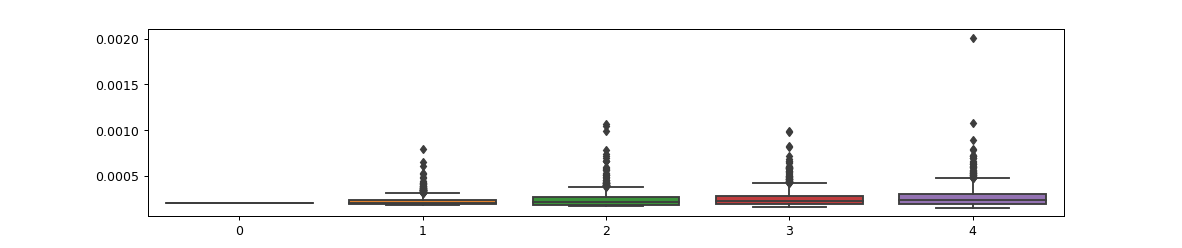

<AxesSubplot: >

In [20]:
sns.boxplot(data=sims.variances[-1])

<IPython.core.display.Javascript object>


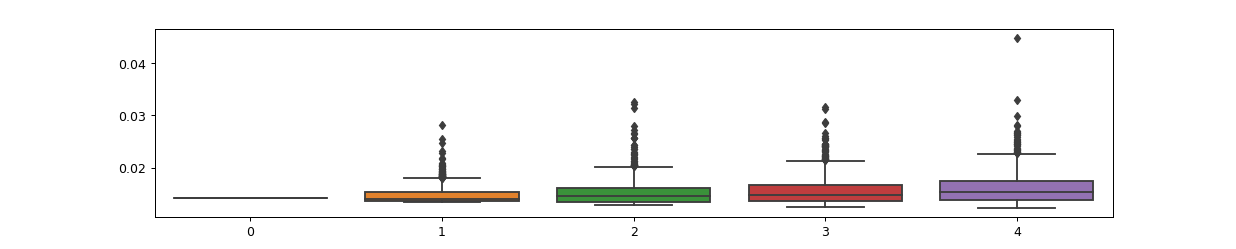

<AxesSubplot: >

In [21]:
sns.boxplot(data=np.sqrt(sims.variances[-1]))

In [22]:
forecasts = result.forecast(start="2019-09-27", method="simulation", reindex=False)
cond_mean = forecasts.mean["2019":]
cond_var = forecasts.variance["2019":]
q = garch_1_1.distribution.ppf([0.01, 0.05])
print(q)

[-2.32634787 -1.64485363]


<IPython.core.display.Javascript object>


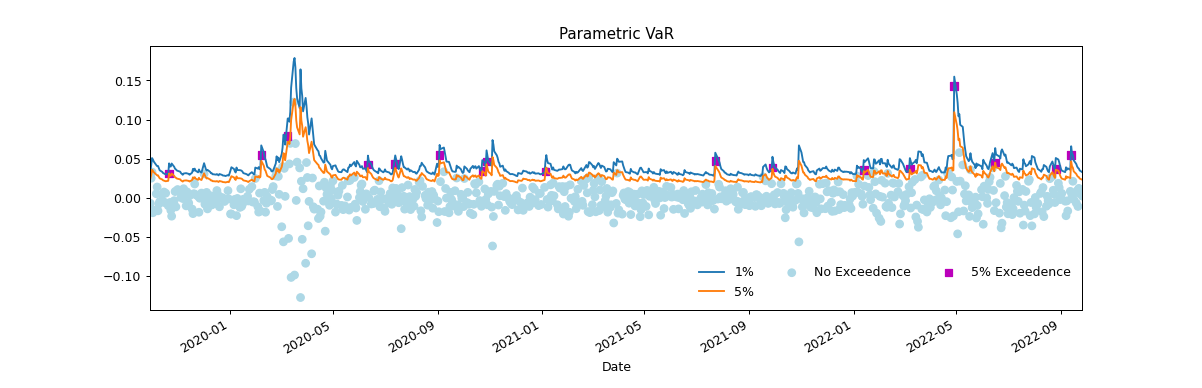

In [24]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]

value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2019 = returns["2019":].copy()
rets_2019.name = "vrsn Return"
c = []
for idx in value_at_risk.index:
    if rets_2019[idx] > -value_at_risk.loc[idx, "5%"]:
        c.append("#ADD8E6")
    elif rets_2019[idx] < -value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {
    "#BB0000": "1% Exceedence",
    "#BB00BB": "5% Exceedence",
    "#ADD8E6": "No Exceedence",
}
markers = {"#BB0000": "x", "#BB00BB": "s", "#ADD8E6": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2019.index[sel],
        -rets_2019.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)

In [27]:
def options_chain(symbol):

    tk = yf.Ticker(symbol)
    exps = tk.options
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + datetime.timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - datetime.datetime.today()).dt.days / 365

    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask

    options = options.drop(columns = ['currency'])

    return options

In [28]:
#yf.Ticker('vrsn').option_chain()

In [29]:
df = options_chain('vrsn')

In [32]:
df

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,expirationDate,dte,CALL,mark
0,VRSN221021C00170000,2022-09-29 19:22:25+00:00,170.0,8.95,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,2022-10-22,0.057534,True,0.00
1,VRSN221021C00175000,2022-09-28 16:42:18+00:00,175.0,6.35,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,2022-10-22,0.057534,True,0.00
2,VRSN221021C00180000,2022-09-29 19:22:25+00:00,180.0,3.40,0.0,0.0,0.0,0.0,1.0,0,0.015635,False,REGULAR,2022-10-22,0.057534,True,0.00
3,VRSN221021C00185000,2022-09-29 19:12:24+00:00,185.0,1.75,0.0,0.0,0.0,0.0,1.0,0,0.062509,False,REGULAR,2022-10-22,0.057534,True,0.00
4,VRSN221021C00190000,2022-09-27 15:01:17+00:00,190.0,1.20,0.0,0.0,0.0,0.0,3.0,0,0.062509,False,REGULAR,2022-10-22,0.057534,True,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,VRSN230317P00180000,2022-09-27 14:42:25+00:00,180.0,15.30,0.0,0.0,0.0,0.0,1.0,0,0.000010,True,REGULAR,2023-03-18,0.460274,False,0.00
106,VRSN230317P00185000,2022-08-15 17:51:57+00:00,185.0,8.30,15.3,17.6,0.0,0.0,17.0,19,0.259559,True,REGULAR,2023-03-18,0.460274,False,16.45
107,VRSN230317P00190000,2022-08-23 16:17:28+00:00,190.0,12.80,18.8,21.9,0.0,0.0,2.0,4,0.280464,True,REGULAR,2023-03-18,0.460274,False,20.35
108,VRSN230317P00200000,2022-08-25 13:57:04+00:00,200.0,17.90,27.1,30.1,0.0,0.0,4.0,11,0.301307,True,REGULAR,2023-03-18,0.460274,False,28.60


<IPython.core.display.Javascript object>


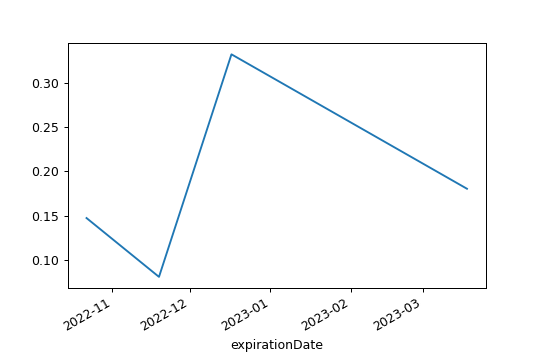

In [33]:
df.groupby('expirationDate')['impliedVolatility'].mean().plot()
plt.show()